In [ ]:
# !gdown --id '1eKNfEuNQadRW1H4NOoMw5sdnyHV14ze0'
# !unzip rtsd-r3.zip

In [ ]:
%cd rtsd-r3

/content/rtsd-r3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
PROJECT_ROOT = pathlib.Path('') #pathlib.Path(os.path.join(os.curdir, os.pardir))
ROOT_DIR = PROJECT_ROOT / 'data'
test_dir_source = ROOT_DIR / 'test'
test_dir = ROOT_DIR / 'test'

In [ ]:
gt_test = pd.read_csv(ROOT_DIR / 'gt_test.csv')
numbers_to_classes = pd.read_csv(ROOT_DIR / 'numbers_to_classes.csv')

gt_test = pd.merge(gt_test, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_test.drop(['class_number'], inplace=True, axis=1)
gt_test['IsPresent'] = pd.Series([1 for x in range(len(gt_test.index))])

del numbers_to_classes

,filename,sign_class,IsPresent
0,000000.png,5_19_1,1
1,000001.png,5_19_1,1
2,000002.png,5_19_1,1
3,000003.png,5_19_1,1
4,000004.png,5_19_1,1
...,...,...,...
22962,022962.png,5_15_5,1
22963,022963.png,5_15_5,1
22964,022964.png,5_15_5,1
22965,022965.png,5_15_5,1


{"5_19_1":4196,"2_1":2314,"5_16":1393,"5_15_2":1348,"3_27":1131,"5_15_3":973,"3_20":761,"5_15_2_2":688,"4_1_1":653,"5_15_5":649,"5_15_1":613,"4_2_1":486,"1_23":462,"2_3_2":404,"3_24_n40":377,"1_22":341,"4_2_3":333,"7_3":308,"4_1_4":295,"5_15_7":287,"6_4":280,"2_3":241,"1_8":233,"2_3_3":231,"1_25":214,"1_11_1":169,"5_20":166,"6_6":152,"3_24_n20":132,"1_11":131,"3_1":115,"4_1_2":114,"1_12":112,"4_2_2":110,"1_17":108,"1_16":106,"6_3_1":105,"5_5":94,"1_14":94,"1_15":90,"3_29":75,"3_24_n70":74,"3_24_n50":74,"3_4_1":73,"3_24_n5":73,"3_2":68,"1_13":64,"4_1_5":63,"7_12":63,"2_2":63,"1_20_2":61,"5_14":59,"5_6":58,"7_7":57,"3_18":52,"1_12_2":47,"4_1_2_1":47,"7_2":46,"1_20":45,"3_28":45,"1_27":45,"1_33":44,"6_2_n20":42,"5_7_1":39,"4_1_2_2":37,"3_19":34,"7_4":34,"7_1":34,"3_32":33,"3_13_r4.5":28,"7_11":27,"4_3":25,"2_5":23,"3_24_n10":23,"7_5":22,"3_18_2":21,"3_30":20,"7_6":18,"1_20_3":17,"6_7":16,"3_24_n60":16,"3_24_n30":15,"6_2_n50":15,"3_10":15,"5_7_2":14,"3_24_n80":13,"1_5":13,"1_1":10,"4_1_3":

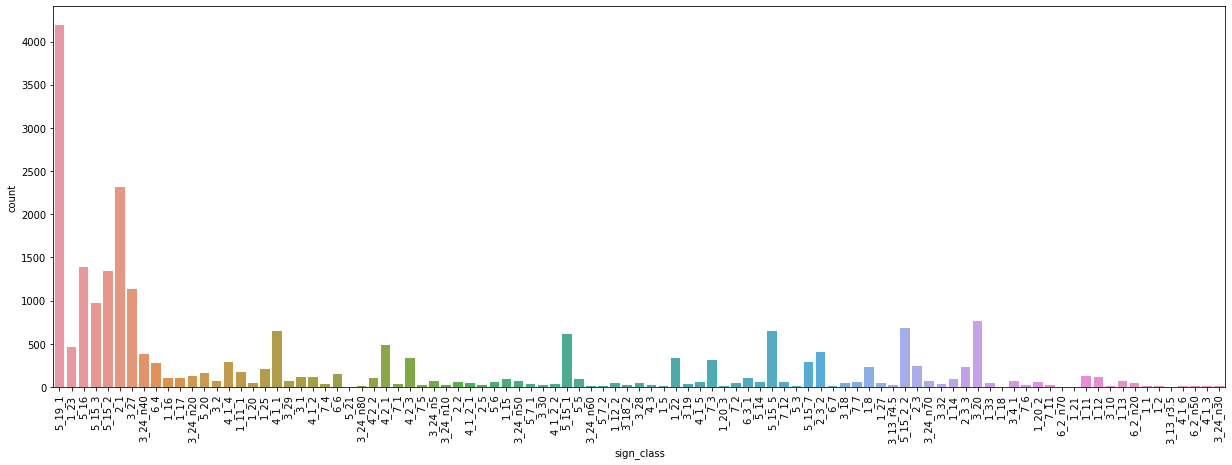

In [ ]:
display(gt_test)
print(gt_test['sign_class'].value_counts().to_json())
_, ax = plt.subplots(figsize=(21, 7))
plt.xticks(rotation=90)
sns.countplot(x='sign_class', data=gt_test, ax=ax);

In [ ]:
EXTRACT_BIG = True
EXTRACT_SPECIFIC_CLASSES = True

if EXTRACT_SPECIFIC_CLASSES == False:
    CLASSES = gt_test['sign_class'].values
    print("[!] Assume classification for all of available classes")
    
else:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    print("[+] Classification for all of those classes:\n", CLASSES)

def printProgressEnum(index, length, label=None):
    print('\r{}Progress: {}/{} ({:.2f}%)'.
                  format(label if label != None else '', index + 1, length, 100 * (index + 1) / length), flush=True, end='')

def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_test.iloc[index]['sign_class']
    if path:
        return gt_test[gt_test['filename']==str(path).split(sep='\\')[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_test[gt_test['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

if EXTRACT_BIG == True:
  
    included_clases = set()
    
    gt_test_size = len(gt_test.index)
    
    for index, row in gt_test.iterrows():

        full_path_to_image = test_dir_source / row['filename']
        
        class_for_current_image = row['sign_class']
                
        if class_for_current_image in CLASSES:
          included_clases.add(class_for_current_image)
          # shutil.copy2(full_path_to_image, train_dir)
        else:
          gt_test.loc[index, 'IsPresent'] = 0
          # print('\n[!]', class_for_current_image, 'is not CLASSES')

        
        if (index % 100 == 0) or (index + 1 == gt_test_size):
            printProgressEnum(index, gt_test_size)
    
    not_included_signs = set(CLASSES) - included_clases
    if not_included_signs:
        print('\n[!] These signs were not included: \n', not_included_signs)

[+] Classification for all of those classes:
 ['1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', '2_3', '2_4', '2_5', '3_1', '3_18', '3_20', '3_21', '3_22', '3_23', '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', '5_19_1', '5_20', '6_3_2', '6_4', '7_3', '7_4']
Progress: 22967/22967 (100.00%)
[!] These signs were not included: 
 {'3_22', '1_31', '3_24_n130', '3_24_n120', '1_6', '3_24_n90', '6_3_2', '3_24_n110', '3_31', '3_21', '3_25', '2_4', '3_23', '3_24_n100'}


In [ ]:
print(gt_test.loc[gt_test['IsPresent'] == 1]['sign_class'].value_counts())
print(np.mean(gt_test.loc[gt_test['IsPresent'] == 1]['sign_class'].value_counts()))

5_19_1      4196
2_1         2314
5_16        1393
3_27        1131
3_20         761
4_1_1        653
3_24_n40     377
1_22         341
7_3          308
6_4          280
2_3          241
1_8          233
5_20         166
3_24_n20     132
3_1          115
5_5           94
3_24_n50      74
3_24_n70      74
2_2           63
5_6           58
3_18          52
3_28          45
1_33          44
7_4           34
4_3           25
3_24_n10      23
2_5           23
3_24_n60      16
3_24_n30      15
3_24_n80      13
1_1           10
Name: sign_class, dtype: int64
429.16129032258067


In [ ]:
MODEL_CLASSES = sorted(list(included_clases))
MODEL_CLASSES

from sklearn import preprocessing
MODEL_LABEL_ENCODER = preprocessing.LabelEncoder()
MODEL_CLASSES_TARGETS = MODEL_LABEL_ENCODER.fit_transform(MODEL_CLASSES)

MODEL_CLASS_MAP = dict(zip(MODEL_CLASSES, MODEL_CLASSES_TARGETS))
MODEL_CLASS_MAP

{'1_1': 0,
 '1_22': 1,
 '1_33': 2,
 '1_8': 3,
 '2_1': 4,
 '2_2': 5,
 '2_3': 6,
 '2_5': 7,
 '3_1': 8,
 '3_18': 9,
 '3_20': 10,
 '3_24_n10': 11,
 '3_24_n20': 12,
 '3_24_n30': 13,
 '3_24_n40': 14,
 '3_24_n50': 15,
 '3_24_n60': 16,
 '3_24_n70': 17,
 '3_24_n80': 18,
 '3_27': 19,
 '3_28': 20,
 '4_1_1': 21,
 '4_3': 22,
 '5_16': 23,
 '5_19_1': 24,
 '5_20': 25,
 '5_5': 26,
 '5_6': 27,
 '6_4': 28,
 '7_3': 29,
 '7_4': 30}

In [ ]:
def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_test.iloc[index]['sign_class']
    if path:
      return gt_test[gt_test['filename']==pathlib.Path(path).parts[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_test[gt_test['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

def getRandomPictureFromTest():
    # instance = gt_test.sample(1)   # fix me or kill me
    while(1):
        instance = gt_test.sample(axis=0)
        # print(instance['IsPresent'].values)
        if instance['IsPresent'].values == 1:
            instance = instance['filename'].values[0]
            break
        
    # print('!', instance)
    path = pathlib.Path(test_dir / instance)
    # print(path)
    return path, getPictureSignClass(path=path)

def showPictureAndClass(path=None, gt_test_index=None):
    if path != None:
        pass
    else:
        if gt_test_index == None:
            assert False, 'cannot identify picture'
        else:
            path = test_dir / gt_test.iloc[gt_test_index]['filename']
    
    sign_class = str(getPictureSignClass(path=path))
    
    fig = plt.figure(figsize=(4, 4))
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.title(f'Label: {sign_class}')
    plt.show()  

data/test/009482.png 7_3


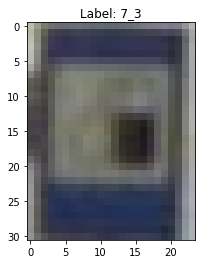

7_3


In [ ]:
path, class_ = getRandomPictureFromTest()
print(path, class_)
showPictureAndClass(path)
print(getPictureSignClass(path=path))

In [ ]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, dir):
        self.df = df[df['IsPresent'] == 1]
        self.dir = dir
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index):
        label = self.df.iloc[index]['sign_class']
        path = self.dir / self.df.iloc[index]['filename']
        # print(path)
        img = cv2.imread(str(path))
        img = cv2.resize(img, (160, 160))
        # print(img)
        img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
        # print(label)
        encoded_label = MODEL_CLASS_MAP[label]
        # print(encoded_label)
        return img_tnsr, encoded_label

In [ ]:
sd = SignDataset(gt_test, test_dir)
sd[3]

(tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.5843, 0.5843, 0.5843],
          [0.7961, 0.7961, 0.7961,  ..., 0.5843, 0.5843, 0.5843],
          [0.7961, 0.7961, 0.7922,  ..., 0.5804, 0.5843, 0.5843],
          ...,
          [0.5843, 0.5843, 0.5843,  ..., 0.4706, 0.4745, 0.4745],
          [0.5843, 0.5843, 0.5843,  ..., 0.4745, 0.4745, 0.4745],
          [0.5843, 0.5843, 0.5843,  ..., 0.4745, 0.4745, 0.4745]],
 
         [[0.6510, 0.6510, 0.6510,  ..., 0.6667, 0.6667, 0.6667],
          [0.6510, 0.6510, 0.6510,  ..., 0.6667, 0.6667, 0.6667],
          [0.6510, 0.6510, 0.6510,  ..., 0.6667, 0.6667, 0.6667],
          ...,
          [0.5647, 0.5647, 0.5647,  ..., 0.5647, 0.5647, 0.5647],
          [0.5647, 0.5647, 0.5647,  ..., 0.5647, 0.5647, 0.5647],
          [0.5647, 0.5647, 0.5647,  ..., 0.5647, 0.5647, 0.5647]],
 
         [[0.5725, 0.5725, 0.5725,  ..., 0.6078, 0.6078, 0.6078],
          [0.5725, 0.5725, 0.5725,  ..., 0.6078, 0.6078, 0.6078],
          [0.5725, 0.5725, 0.5725,  ...,

In [ ]:
batch_size_ = 512
test_loader = torch.utils.data.DataLoader(
        SignDataset(gt_test, test_dir),
        batch_size=batch_size_,
        pin_memory=True,
        shuffle=True,
        num_workers=2,
    )
next(iter(test_loader))

[tensor([[[[0.6471, 0.6471, 0.6471,  ..., 0.6510, 0.6510, 0.6510],
           [0.6471, 0.6471, 0.6471,  ..., 0.6510, 0.6510, 0.6510],
           [0.6471, 0.6471, 0.6471,  ..., 0.6510, 0.6510, 0.6510],
           ...,
           [0.3059, 0.3059, 0.3059,  ..., 0.3412, 0.3412, 0.3412],
           [0.3059, 0.3059, 0.3059,  ..., 0.3412, 0.3412, 0.3412],
           [0.3059, 0.3059, 0.3059,  ..., 0.3412, 0.3412, 0.3412]],
 
          [[0.6549, 0.6549, 0.6549,  ..., 0.6471, 0.6471, 0.6471],
           [0.6549, 0.6549, 0.6549,  ..., 0.6471, 0.6471, 0.6471],
           [0.6549, 0.6549, 0.6549,  ..., 0.6471, 0.6471, 0.6471],
           ...,
           [0.3020, 0.3020, 0.3020,  ..., 0.3137, 0.3137, 0.3137],
           [0.3020, 0.3020, 0.3020,  ..., 0.3137, 0.3137, 0.3137],
           [0.3020, 0.3020, 0.3020,  ..., 0.3137, 0.3137, 0.3137]],
 
          [[0.6588, 0.6588, 0.6588,  ..., 0.6549, 0.6549, 0.6549],
           [0.6588, 0.6588, 0.6588,  ..., 0.6549, 0.6549, 0.6549],
           [0.6588, 0.65

In [ ]:
from torchvision import models, transforms as transforms
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, len(MODEL_CLASSES))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_batch_accuracy(y_pred, y_true):
    '''
    Оценка точности предсказания (accuracy)

    y_pred:
        батч сырых степеней уверенности, размер (N, K)
    y_true:
        вектор истинных значений, размер (N)
    '''
    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    # print(y_true)
    # print(y_pred)
    accuracy = 0
    for i in range(len(y_true)):
        index_max = max(range(len(y_pred[i, :])), key=y_pred[i].__getitem__)
        # print(index_max)
        if (index_max == y_true[i]):
            accuracy += 1
    accuracy /= len(y_pred)
    return accuracy
    
def valid_epoch(model, loader, loss):
    acc_ = []
    torch.set_grad_enabled(False)
    # Таким образом переводим модель в режим исполнения (inference)
    # В этом режиме отключены градиенты, он быстрее, 
    #   но в нём нельзя обучать модель
    model.eval()
    for batch_idx, (imgs_batch, labels_batch) in enumerate(loader):
        imgs_batch = imgs_batch.to(device)
        #print(labels_batch)
        labels_batch = labels_batch.to(device)
        
        pred = model(imgs_batch)
        
        local_acc = evaluate_batch_accuracy(pred.cpu(), labels_batch.cpu())
        acc_.append(local_acc)
        
        # model.addValidHistoryAcc(local_acc)
        
        if batch_idx % 20 == 0:
            print('\rValid Epoch: {} [{}/{} ({:.2f}%)]'.
                  format(epoch, batch_idx * len(imgs_batch), len(loader.dataset),
                 100 * batch_idx * len(imgs_batch) / len(loader.dataset)), flush=True, end='')
        
    print('\rValid Epoch: {} [{}/{} (100%)]     \n'.
                  format(epoch, len(loader.dataset), len(loader.dataset)), flush=True, end='')
    
    return np.mean(acc_)

In [ ]:
%cp '/resnet18_rtsd_test_11.09_23.09_loss0.4226_acc_0.9067' /content/rtsd-r3/

In [ ]:
if os.path.isfile('resnet18_rtsd_test'):
    model.load_state_dict(torch.load('resnet18_rtsd_test', map_location=torch.device('cpu')))
    print('[+] Model restored from save file!')
else:
  print('NF')


loss_op = nn.CrossEntropyLoss()
epoch = 1
valid_epoch(model, test_loader, loss_op)

[+] Model restored from save file!
Valid Epoch: 1 [13304/13304 (100%)]     


0.8783792162698413

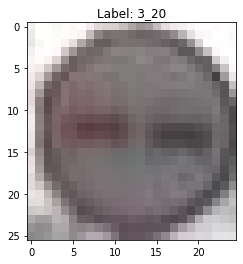

'3_20'

In [ ]:
path, class_ = getRandomPictureFromTest()

showPictureAndClass(path)

img = cv2.imread(str(path))
img = cv2.resize(img, (160, 160))
img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)

pred = model(img_tnsr[None, ...]).numpy()
# print(pred)
MODEL_CLASS_MAP_I = dict(zip(MODEL_CLASSES_TARGETS, MODEL_CLASSES))

MODEL_CLASS_MAP_I[np.argmax(pred)]

In [ ]:
%pwd